## Note: Increased IOPub
For visualization, if you did not start this notebook with an increased data rate limit, stop the notebook, go back to the command line, and start Jupyter Notebook using the following command.

`jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000`

# Import the Python API module and Instantiate the GIS object

Import the Python API

In [1]:
import arcgis
from getpass import getpass

Create an GIS object instance using the [account currently logged in through ArcGIS Pro](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#ArcGIS-Pro-user-connecting-to-the-active-portal-in-the-Pro-app)

In [2]:
#gis_retail = arcgis.gis.GIS('Pro')  # optional, use if can use ArcGIS Pro authentication
gis_retail = arcgis.gis.GIS(
    username='jmccune_retail',  # change this to your username 
    password=getpass('Please enter your password: ')
)

Please enter your password: ········


# Get a Feature Set, data to work with, from the Web GIS Item ID

Create a [Web GIS Item](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#item) instance using the Item ID

<Item title:"targetWithDemographics" type:Feature Layer Collection owner:joel5174@esri.com_commteamretail>
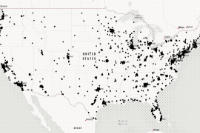

In [3]:
trade_area_itemid = '44c0b666404c41b8a14e04c34d09be1e'
item = arcgis.gis.Item(gis=gis_retail, itemid=trade_area_itemid)
item

Since the item only contains one feature layer, get the first layer in the item, the [Feature Layer](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurelayer) we need to work with.

In [4]:
feature_layer = item.layers[0]
feature_layer

<FeatureLayer url:"https://services.arcgis.com/PMTtzuTB6WiPuNSv/arcgis/rest/services/targetWithDemographics/FeatureServer/0">

Now, for this initial analysis, [query](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.query) to return just the attributes for the eight minute trade areas as a [Feature Set](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset).

In [5]:
feature_set = feature_layer.query()

# Convert the Data into a Pandas Data Frame

Take advantage of the [`df` function](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureSet.df) on the Feature set object returned from the query to convert the data to a [Pandas Data Frame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [6]:
data_frame = feature_set.df
data_frame.head()

,OBJECTID,Target_Locations_CITY,Target_Locations_CONAME,Target_Locations_LOCNUM,Target_Locations_NAICS,Target_Locations_SALESVOL,Target_Locations_SIC,Target_Locations_SQFTCODE,Target_Locations_STATE,Target_Locations_STREET,...,overlayTemplate_VAL200K_CY,overlayTemplate_VAL250K_CY,overlayTemplate_VAL300K_CY,overlayTemplate_VAL400K_CY,overlayTemplate_VAL500K_CY,overlayTemplate_VAL50K_CY,overlayTemplate_VAL750K_CY,overlayTemplate_WHITE_CY,overlayTemplate_WIDOWED_CY,SHAPE
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,200,354,934,693,1976,81,1012,23576,1902,"{'x': -13563500.716724824, 'y': 4386409.918831..."
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,137,270,1043,742,1612,81,588,21068,1500,"{'x': -13559960.756917607, 'y': 4392875.237199..."
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,372,405,1015,1271,4018,261,2452,41050,2524,"{'x': -13577092.826550681, 'y': 4435664.48477165}"
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,456,449,870,982,1211,197,293,19905,1323,"{'x': -13555819.671860088, 'y': 4427321.189443..."
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,43,49,211,519,2823,110,7694,41689,5226,"{'x': -13585007.642346086, 'y': 4484238.960603..."


# Save dependent and independent variable names as Python variables

Use a quick list comprehension to create a list of field names to be used as independent variables.

In [7]:
field_name_independent_list = [field['name'] for field in feature_set.fields if 
    field['type'] != 'esriFieldTypeOID' and  # we don't need the Esri object identifier field
    field['name'].startswith('Shape_') == False and  # exclude the Esri shape fields
    (field['type'] == 'esriFieldTypeInteger' or field['type'] == 'esriFieldTypeDouble') and  # ensure numeric, quantatative, fields are the only fields used
    'SALESVOL' not in field['name']   # exclude the dependent variable
]
print(field_name_independent_list)

['overlayTemplate_TOTPOP_CY', 'overlayTemplate_HHPOP_CY', 'overlayTemplate_FAMPOP_CY', 'overlayTemplate_GQPOP_CY', 'overlayTemplate_POPDENS_CY', 'overlayTemplate_TOTHH_CY', 'overlayTemplate_AVGHHSZ_CY', 'overlayTemplate_FAMHH_CY', 'overlayTemplate_AVGFMSZ_CY', 'overlayTemplate_TOTHU_CY', 'overlayTemplate_OWNER_CY', 'overlayTemplate_RENTER_CY', 'overlayTemplate_VACANT_CY', 'overlayTemplate_POPGRW10CY', 'overlayTemplate_HHGRW10CY', 'overlayTemplate_FAMGRW10CY', 'overlayTemplate_NOHS_CY', 'overlayTemplate_SOMEHS_CY', 'overlayTemplate_HSGRAD_CY', 'overlayTemplate_GED_CY', 'overlayTemplate_SMCOLL_CY', 'overlayTemplate_ASSCDEG_CY', 'overlayTemplate_BACHDEG_CY', 'overlayTemplate_GRADDEG_CY', 'overlayTemplate_NEVMARR_CY', 'overlayTemplate_MARRIED_CY', 'overlayTemplate_WIDOWED_CY', 'overlayTemplate_DIVORCD_CY', 'overlayTemplate_WHITE_CY', 'overlayTemplate_BLACK_CY', 'overlayTemplate_AMERIND_CY', 'overlayTemplate_ASIAN_CY', 'overlayTemplate_PACIFIC_CY', 'overlayTemplate_OTHRACE_CY', 'overlayTemp

Also, save the name of the dependent variable field as well.

In [8]:
field_name_dependent = [field['name'] for field in feature_set.fields if 'SALESVOL' in field['name']][0]
field_name_dependent

'Target_Locations_SALESVOL'

# Store Segmentation Using KMeans Clustering

Use KMeans cluster analysis from the Sci-Kit Learn package to segment the demographically similar stores together.

In [9]:
from sklearn.cluster import KMeans

Create the KMeans clusterer, specifying it to create five clusters, or segments.

In [10]:
kmcluster = KMeans(n_clusters=5)

Use the `fit_predict` method to create the clusters.

In [11]:
data_frame['segment'] = kmcluster.fit_predict(data_frame[field_name_independent_list])

Now, take a look at a few descriptive metrics to begin to understand the results.

In [12]:
df_count = data_frame.segment.value_counts().reset_index().rename(columns={'index': 'segment', 'segment': 'count'})
df_mean = data_frame.groupby('segment').mean()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'mean_sales'})
df_median = data_frame.groupby('segment').median()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'median_sales'})

In [13]:
df_summary = df_count.join(df_mean, on='segment', rsuffix='mean').join(
    df_median, on='segment', rsuffix='median').sort_values('mean_sales', ascending=False).drop(
    ['segmentmean', 'segmentmedian'], axis=1)
df_summary

,segment,count,mean_sales,median_sales
4,3,52,45732.500000,42130.5
3,2,208,40657.115385,35495.0
2,0,360,38065.166667,35495.0
1,4,536,34590.748134,33751.0
0,1,652,31391.226994,32268.0


In [14]:
df_top_performing = data_frame[data_frame.segment == 2]
df_top_performing.head()

,OBJECTID,Target_Locations_CITY,Target_Locations_CONAME,Target_Locations_LOCNUM,Target_Locations_NAICS,Target_Locations_SALESVOL,Target_Locations_SIC,Target_Locations_SQFTCODE,Target_Locations_STATE,Target_Locations_STREET,...,overlayTemplate_VAL250K_CY,overlayTemplate_VAL300K_CY,overlayTemplate_VAL400K_CY,overlayTemplate_VAL500K_CY,overlayTemplate_VAL50K_CY,overlayTemplate_VAL750K_CY,overlayTemplate_WHITE_CY,overlayTemplate_WIDOWED_CY,SHAPE,segment
8,9,SAN JOSE,TARGET,435039879,45211101,35495,531102,D,CA,COTTLE RD,...,765,2517,4531,12939,862,2895,60248,3932,"{'x': -13559148.12463481, 'y': 4473997.103413295}",2
10,11,SANTA CLARA,TARGET,706082503,45211101,35495,531102,D,CA,EL CAMINO REAL,...,234,1024,2219,11352,143,5843,64144,4600,"{'x': -13576591.888842113, 'y': 4488327.293081...",2
13,14,SAN JOSE,TARGET,230020265,45211101,59158,531102,D,CA,SILVER CREEK RD,...,1079,3609,4905,9288,951,2819,45850,6138,"{'x': -13560116.604204714, 'y': 4482083.425111...",2
19,20,SAN BRUNO,TARGET,988513198,45211101,118317,531102,D,CA,EL CAMINO REAL,...,485,1276,1917,9866,129,5783,43606,6359,"{'x': -13627620.743421752, 'y': 4528258.185799...",2
21,22,FOSTER CITY,TARGET,974408171,45211101,47327,531102,C,CA,BRIDGEPOINTE PKWY,...,140,539,1035,6319,77,5222,42560,3881,"{'x': -13612570.348266501, 'y': 4517495.816248...",2


# Map Results

I am trying to visualize the data results. For some stupid reason, I cannot seem to get anything to show up. Both the map and the data frame data are both in Web Mercator, so it is not the spatial reference...so I'm really confused.

In [15]:
store_map = gis_retail.map('USA')

In [16]:
top_performing_feature_set = arcgis.features.FeatureSet.from_dataframe(df_top_performing)

In [19]:
store_map.draw(top_performing_feature_set, symbol={"type": "esriSMS","style": "esriSMSCircle", "size": 8})

In [20]:
store_map